In [112]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### 1) Importer le dataset

In [113]:
dataset=pd.read_csv("CarPrice.csv")
dataset = pd.DataFrame(dataset)
dataset.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### 2) Nettoyage de Data

In [114]:
# Prétraitement des données CarPrice

# Extraire la marque depuis CarName
dataset['brand'] = dataset['CarName'].apply(lambda x: x.split(' ')[0].lower())

# Encoder les variables catégorielles
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_cols = ['brand', 'fueltype', 'aspiration', 'doornumber', 'carbody',
                   'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']

for col in categorical_cols:
    dataset[col + '_encoded'] = le.fit_transform(dataset[col])

dataset.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,brand_encoded,fueltype_encoded,aspiration_encoded,doornumber_encoded,carbody_encoded,drivewheel_encoded,enginelocation_encoded,enginetype_encoded,cylindernumber_encoded,fuelsystem_encoded
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,0,1,0,1,0,2,0,0,2,5
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,0,1,0,1,0,2,0,0,2,5
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,0,1,0,1,2,2,0,5,3,5
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,1,1,0,0,3,1,0,3,2,5
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,1,1,0,0,3,0,0,3,1,5


### 3) Définition des x et y initial

In [115]:
#Création de X et Y
feature_cols = ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
               'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
               'horsepower', 'peakrpm', 'citympg', 'highwaympg'] + [col + '_encoded' for col in categorical_cols]

X = dataset[feature_cols].values
y = dataset[['price']].values

y = y.reshape(y.shape[0],1)

### 4) Séparation des données en données & Sélection de degré en minimisant l'erreur de test

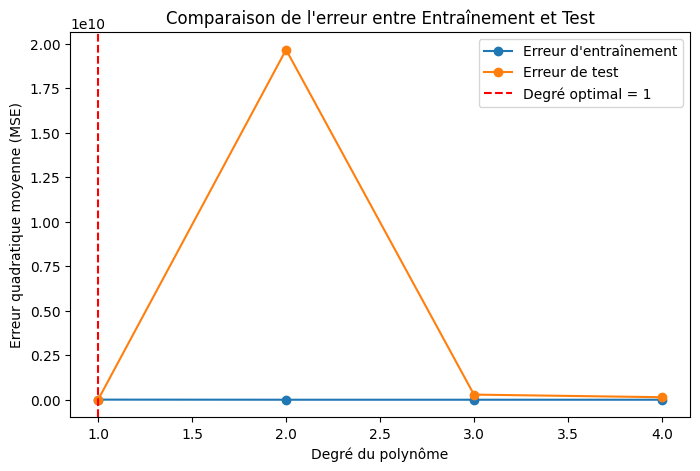

Degré optimal sélectionné selon l'erreur de test : 1
Original features: 24
Polynomial features: 24


In [116]:
#data split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tester plusieurs degrés de polynôme
degrees = range(1, 5)
train_errors = []
test_errors = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, Y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calcul de l'erreur quadratique moyenne (MSE)
    train_mse = mean_squared_error(Y_train, y_train_pred)
    test_mse = mean_squared_error(Y_test, y_test_pred)
    
    train_errors.append(train_mse)
    test_errors.append(test_mse)

# Trouver le degré optimal selon l'erreur de test minimale
optimal_degree_test = degrees[np.argmin(test_errors)]

# Affichage des erreurs en fonction du degré du polynôme
plt.figure(figsize=(8, 5))
plt.plot(degrees, train_errors, label="Erreur d'entraînement", marker='o')
plt.plot(degrees, test_errors, label="Erreur de test", marker='o')
plt.axvline(optimal_degree_test, color='red', linestyle='--', label=f"Degré optimal = {optimal_degree_test}")
plt.xlabel("Degré du polynôme")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.title("Comparaison de l'erreur entre Entraînement et Test")
plt.legend()
plt.show()

print(f"Degré optimal sélectionné selon l'erreur de test : {optimal_degree_test}")

# Création des features polynomiales (degré 2 avec interactions seulement)
poly_features = PolynomialFeatures(degree=optimal_degree_test, include_bias=False, interaction_only=True)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")

# Mettre à jour X_train et X_test avec les features polynomiales
X_train = X_train_poly
X_test = X_test_poly

### 5) Fonction de normalisation from scratch

In [117]:
#fct de normalisation from scratch
def z_score_normalised (data):
    mean = np.mean(data, axis=0)  #calcul de moyenne
    std = np.std(data, axis=0)  #calcul de l'écart type
    # Éviter la division par zéro pour les features constantes
    std = np.where(std == 0, 1, std)
    data_normalized = (data - mean) / std
    return data_normalized, mean, std

##### * Normalisation  des données at ajout de la colonne des 1

In [118]:
from sklearn.discriminant_analysis import StandardScaler
# 1. Calculer mean et std sur le Train uniquement
X_train_norm, mean_train, std_train = z_score_normalised(X_train)

# 2. Appliquer ces mêmes valeurs sur le Test
X_test_norm = (X_test - mean_train) / std_train

scaler_y = StandardScaler()

# 2. Adapter sur le Train et transformer (Attention au reshape)
# reshape(-1, 1) est nécessaire car sklearn attend une matrice 2D
Y_train_norm = scaler_y.fit_transform(Y_train.reshape(-1, 1))

# 3. Transformer le Test (ne pas re-fit !)
Y_test_norm = scaler_y.transform(Y_test.reshape(-1, 1))

# 3. Ajout de la colonne des 1 (Bias)
X_train_norm = np.hstack((X_train_norm, np.ones((X_train_norm.shape[0], 1))))
X_test_norm = np.hstack((X_test_norm, np.ones((X_test_norm.shape[0], 1))))

print(X_test_norm[:5])
scaler_y

[[-0.72738032  0.80181738  1.23488746  0.4617128   0.80270819  1.31974439
   2.04695639  1.11230832  0.42626174 -0.54369235  1.92739928  0.51955385
  -1.47623697 -1.33631113 -1.56102447  0.31728716 -0.46348119 -0.91798509
   0.45721393  1.19131812 -0.13650473  0.04963143  1.13782697  0.85588374
   1.        ]
 [-0.72738032  0.12962287  0.33814986  0.93408272 -0.69416744  0.97293873
   0.11365263 -0.70964636  0.4578153  -0.80394612  1.37884232  0.72266906
  -1.47623697 -1.33631113 -1.69705423  0.31728716  2.15758486  1.08934231
  -0.69637199 -2.46057295 -0.13650473  0.04963143 -1.47201391  0.85588374
   1.        ]
 [-0.72738032 -0.25688897 -0.06040018 -0.34131607  0.39814721 -0.49853612
  -0.15899277  0.03400861  0.67869027 -0.41356546 -0.19202534  0.11332343
   0.31350194  0.53414428 -0.06469708  0.31728716 -0.46348119 -0.91798509
   0.45721393 -0.63462741 -0.13650473  0.04963143 -0.16709347 -1.12807291
   1.        ]
 [ 1.69066776  0.06240342  1.03561244  0.27276483  0.96453258  0.19

,copy,True
,with_mean,True
,with_std,True


### 6) Theta initial

In [119]:
#création de thetha initial
np.random.seed(42)
theta_initial=np.random.randn(X_train.shape[1]+1,1) * 0.1  # Better initialization
print('Number of features:', X_train.shape[1])
print('Theta shape:', theta_initial.shape)

Number of features: 24
Theta shape: (25, 1)


### 7) le Modèle

In [120]:
#def du model
def model(X, theta):
    return X.dot(theta)

### 8) Fonction cout

In [121]:
def cost_function(X, y, theta, a):
    m = len(y)
    # On ajoute [1:] pour ignorer le premier élément (le biais) dans la pénalité
    return 1/(2*m) * np.sum((model(X, theta) - y)**2) + a/m * np.linalg.norm(theta[1:], ord=1)

In [122]:
# Affichage coût des erreurs du modèle initial 
print("L'erreur du modèle initial : ", cost_function(X_train_norm, Y_train_norm, theta_initial, a = 0))

L'erreur du modèle initial :  0.28738217706357344


### 9) Gradients et descente de gradient

In [123]:
def grad(X, y, theta, a):
    m = len(y)
    # Calcul du gradient classique (MSE)
    gradient = 1/m * X.T.dot(model(X, theta) - y)
    
    # Calcul du terme Lasso
    lasso_term = a/m * np.sign(theta)
    lasso_term[0] = 0  # <--- IMPORTANT : On annule la pénalité pour le biais (theta[0])
    
    return gradient + lasso_term

In [124]:
def gradient_descent(X, y, theta, learning_rate, n_iterations, a):
    
    cost_history = np.zeros(n_iterations) # création d'un tableau de stockage pour enregistrer l'évolution du Cout du modele
    
    for i in tqdm(range(n_iterations), desc="Training Progress"):
        theta = theta - learning_rate * grad(X, y, theta, a) # mise a jour du parametre theta (formule du gradient descent)
        cost_history[i] = cost_function(X, y, theta, a) # on enregistre la valeur du Cout au tour i dans cost_history[i]
        
    return theta, cost_history

### 10) Phase d'entrainement

In [125]:
n_iterations = 15000
learning_rate = 0.01
a = 0.2  # Light regularization for polynomial features

theta_final, cost_history = gradient_descent(X_train_norm, Y_train_norm, theta_initial, learning_rate, n_iterations, a)
print('theta final:',theta_final)

Training Progress: 100%|██████████| 15000/15000 [00:00<00:00, 25060.28it/s]

theta final: [[ 2.40414271e-02]
 [ 1.04339748e-01]
 [-2.62351512e-02]
 [ 1.72079178e-01]
 [ 6.07327961e-02]
 [ 1.24388018e-01]
 [ 4.14534124e-01]
 [-2.91920730e-02]
 [-9.12491205e-02]
 [ 1.55882929e-01]
 [ 1.31001880e-01]
 [ 8.92607193e-02]
 [-4.33635767e-02]
 [ 3.96121747e-03]
 [-1.29112537e-01]
 [ 8.61898863e-02]
 [ 2.06941074e-02]
 [-8.72750166e-02]
 [-1.23485323e-01]
 [ 5.50733758e-02]
 [ 1.94769099e-01]
 [ 3.82559400e-02]
 [-1.03767652e-02]
 [ 2.65325870e-02]
 [-6.12820198e-06]]


### 11) Création d'un vecteur prédictions qui contient les prédictions de notre modele final

In [126]:
predictions = model(X_test_norm, theta_final)

### 12) Courbe d'apprentissage

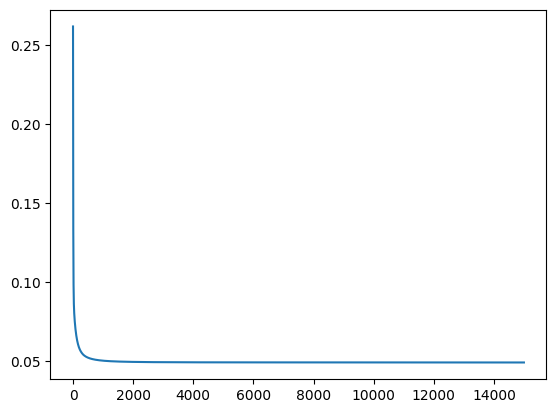

In [127]:
plt.plot(range(n_iterations), cost_history)
plt.show()

### 13) Evaluation du modèle - Coefficient de détermination

In [128]:
def coef_determination(y, pred):
    u = ((y - pred)**2).sum()
    v = ((y - y.mean())**2).sum()
    return 1 - u/v

In [129]:
r2_score = coef_determination(Y_test_norm, predictions)
print("Le coefficient de determination de notre modèle est : ", r2_score)

Le coefficient de determination de notre modèle est :  0.8513093898688346


### Sauvegarde des variables

In [130]:
import joblib

# Créer un dictionnaire des encoders
encoders_dict = {}
for col in categorical_cols:
    encoders_dict[col] = LabelEncoder().fit(dataset[col])

# On sauvgarde les éléments nécessaires pour faire des prédictions sur le fichier app.py
artefacts = {
    "modele_poids": theta_final,   # Vos thétas calculés
    "poly_features": poly_features,  # Le transformateur de features polynomiales
    "x_mean": mean_train,          # Votre moyenne manuelle
    "x_std": std_train,            # Votre écart-type manuel
    "y_scaler": scaler_y,          # Le scaler sklearn pour le prix
    "feature_columns": feature_cols,  # Les colonnes utilisées
    "categorical_cols": categorical_cols,  # Colonnes catégorielles
    "encoders": encoders_dict  # Encoders pour chaque colonne
}

# Sauvegarde dans un fichier
joblib.dump(artefacts, 'modele_cars.pkl')
print("Fichier 'modele_cars.pkl' sauvegardé avec succès !")

Fichier 'modele_cars.pkl' sauvegardé avec succès !
